In [7]:
import numpy as np
import sympy as smp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from IPython.display import HTML

In [8]:
# Constants
t = smp.symbols('t')
m1, m2, k1, k2, k3 = smp.symbols('m1 m2 k1 k2 k3')

# Linear functions of time
x1, x2, = smp.symbols(r'\x_1, \x_2', cls=smp.Function)
x1 = x1(t)
x2 = x2(t)

def get_derivatives(x1, x2):

    v1 = smp.diff(x1, t)
    v2 = smp.diff(x2, t)
    a1 = smp.diff(v1, t)
    a2 = smp.diff(v2, t)

    return v1, v2, a1, a2

def get_Lagrangian(x1, x2, v1, v2):

    T = (1/2)*(m1)*(v1**2) + (1/2)*(m2)*(v2**2)
    V = (1/2)*(k1)*(x1**2) + (1/2)*(k3)*(x2**2) + (1/2)*(k2)*((x2 - x1)**2)
    L = T - V

    return L

def solve_Lagrange_equations(L, x1, x2, v1, v2, a1, a2, t):

    LE1 = smp.diff(L, x1) - smp.diff(smp.diff(L, v1), t).simplify()
    LE2 = smp.diff(L, x2) - smp.diff(smp.diff(L, v2), t).simplify()
    sols = smp.solve([LE1, LE2], (a1, a2), simplify=False, rational=False)

    return sols

def Lambdify(v1, v2, a1, a2, sols):

    dz1dt_f = smp.lambdify((t,m1,m2,k1,k2,k3,x1,x2,v1,v2), sols[a1])
    dz2dt_f = smp.lambdify((t,m1,m2,k1,k2,k3,x1,x2,v1,v2), sols[a2])
    dx1dt_f = smp.lambdify(v1, v1)
    dx2dt_f = smp.lambdify(v2, v2)

    return dz1dt_f, dz2dt_f, dx1dt_f, dx2dt_f

def dSdt(S, t, m1, m2, k1, k2, k3):

    x1, z1, x2, z2 = S

    return [
        dx1dt_f(z1),
        dz1dt_f(t, m1, m2, k1, k2, k3, x1, x2, z1, z2),
        dx2dt_f(z2),
        dz2dt_f(t, m1, m2, k1, k2, k3, x1, x2, z1, z2),
    ]

def get_x1x2_hist(t, x1, x2):
    return x1, x2

def animate(i):
    
    ln1.set_data([-5, x1_hist[i]], [0, 0])  
    ln2.set_data([x1_hist[i], x2_hist[i]], [0, 0])  
    ln3.set_data([x2_hist[i], 5], [0, 0])  

    # Update the red markers for the masses
    markers.set_data([x1_hist[i], x2_hist[i]], [0, 0])
    return ln1, ln2, ln3, markers

v1, v2, a1, a2 = get_derivatives(x1, x2)
L = get_Lagrangian(x1, x2, v1, v2)
sols = solve_Lagrange_equations(L, x1, x2, v1, v2, a1, a2, t)
dz1dt_f, dz2dt_f, dx1dt_f, dx2dt_f = Lambdify(v1, v2, a1, a2, sols)

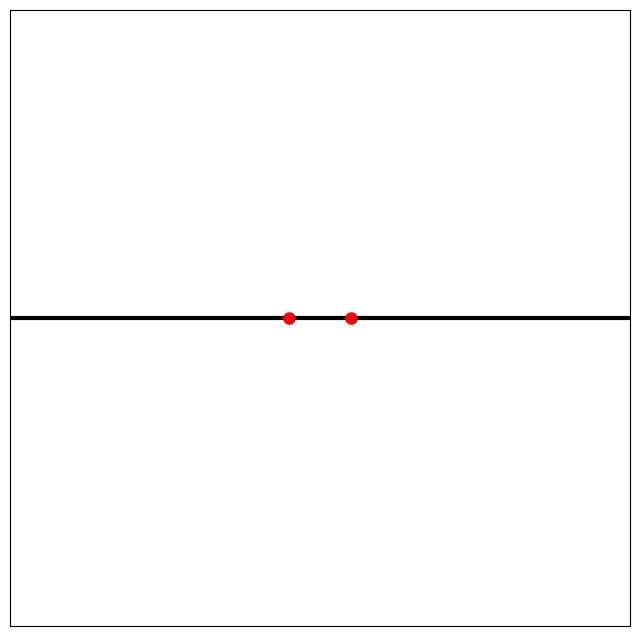

In [9]:
t = np.linspace(0, 20, 101)
m1 = 1
m2 = 1
k1 = 1
k2 = 1
k3 = 1

# initial conditions: x1, v1, x2, v2
y0 = [-0.5, 0.0, 0.5, 0.0]

ans = odeint(dSdt, y0, t, args=(m1, m2, k1, k2, k3))
x1_hist, x2_hist = get_x1x2_hist(t, ans.T[0], ans.T[2])
fig, ax = plt.subplots(1,1, figsize=(8,8)) 
ax.set_facecolor('white') 
ax.get_xaxis().set_ticks([])    
ax.get_yaxis().set_ticks([])    
ln1, = plt.plot([], [], 'k-', lw=3)  
ln2, = plt.plot([], [], 'k-', lw=3)  
ln3, = plt.plot([], [], 'k-', lw=3)  
markers, = plt.plot([], [], 'ro', markersize=8)  
ax.set_ylim(-1, 1)
ax.set_xlim(-5, 5)
ani = animation.FuncAnimation(fig, animate, frames=len(t), interval=50)
# HTML(ani.to_jshtml())
ani.save('pen.gif',writer='pillow',fps=25)